# Naive modeling of credit defaults using a Markov Random Field

<table><tr><td>
    <a href="http://agrum.org" target="blank"><img src="images/logoAgrum.png"/></a>
    </td><td>
    <a href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" src="images/cc4.png" /></a>
    <br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.<p>
    Authors: <b>Marvin Lasserre</b> and Pierre-Henri Wuillemin.</p>
</td></tr></table>

This notebook is the adaptation to pyAgrum of the  [model proposed by Gautier Marti](https://marti.ai/quant/2022/01/30/default-distribution-mrf.html) which is itself inspired by the paper [Graphical Models for Correlated Defaults](https://arxiv.org/pdf/0809.1393.pdf).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.mn2graph as m2g

### Constructing the model 

Three sectors co-dependent in their stress state are modelled: (```Finance```, ```Energy```, ```Retail```).
For each of these sectors, we consider a universe of three issuers.

<table width="100%"><tr><td>
    Within <tt>Finance</tt>:
    <ul>
        <li>Deutsche Bank</li>
        <li>Metro Bank</li>
        <li>Barclays</li>
    </ul>
</td><td>
    Within <tt>Energy</tt>
    <ul>
        <li>EDF</li>
        <li>Petrobras</li>
        <li>EnQuest</li>
    </ul>
</td><td>
    Within <tt>Retail</tt>
    <ul>
        <li>New Look</li>
        <li>Matalan</li>
        <li>Marks & Spencer</li>
    </ul>
</td></tr></table>
    
The probability of default of these issuers is partly idiosyncratic and partly depending on the stress within their respective sectors. Some distressed names such as New Look can have a high marginal probability of default, so high that the state of their sector (normal or stressed) does not matter much. Some other high-yield risky names such as Petrobras may strongly depend on how the whole energy sector is doing. On the other hand, a company such as EDF should be quite robust, and would require a very acute and persistent sector stress to move its default probability significantly higher.

We can encode this basic knowledge in terms of potentials:

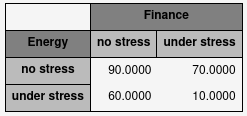

Conventions:

Sector variables can be either in the state ```no stress``` or in the state ```under stress``` while issuer variables can be either in the state ```no default``` or in the state ```default```.

The choice of these potentials is not an easy task; It can be driven by historical fundamental or statistical relationships or forward-looking views.

Given a network structure, and a set of potentials, one can mechanically do inference using the pyAgrum library.

We will show how to obtain a distribution of the number of defaults (and the expected number of defaults), a distribution of the losses (and the expected loss). From the joint probability table, we could also extract the default correlation

<strong>tl;dr</strong> We use here the library [pyAgrum](https://agrum.org) to illustrate, on a toy example, how one can use a Markov Random Field (MRF) for modelling the distribution of defaults and losses in a credit portfolio.

Building accurate PGM/MRF models require expert knowledge for considering a relevant graph structure, and attributing useful potentials. For this toy model, we use the following structure:

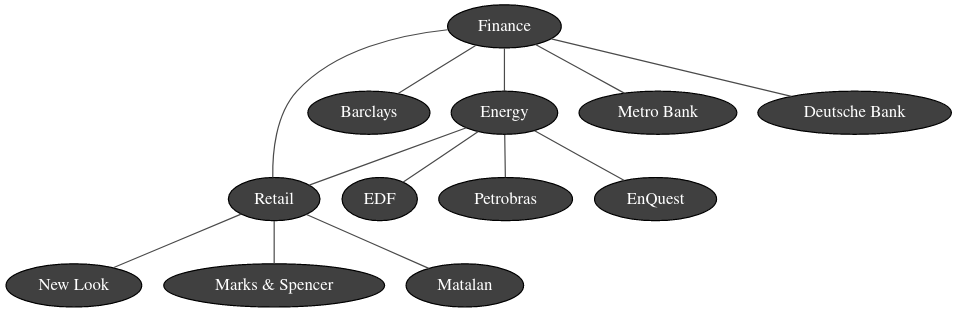

The first step consists in creating the model.
For that, we use the pyAgrum class ```MarkovNet```.

In [2]:
# building nodes (with types)
mn = gum.MarkovNet('Credit default modeling')

# Adding sector variables
sectors = ['Finance', 'Energy', 'Retail']
finance, energy, retail = [mn.add(gum.LabelizedVariable(name, '', ['no stress', 'under stress'])) 
                           for name in sectors]

# Adding issuer variables
edf, petro, eq = [mn.add(gum.LabelizedVariable(name, '', ['no default', 'default'])) 
              for name in ['EDF','Petrobras','EnQuest']]

mb, db, ba = [mn.add(gum.LabelizedVariable(name, '', ['no default', 'default'])) 
              for name in ['Metro Bank', 'Deutsche Bank', 'Barclays']]

nl, matalan, ms = [mn.add(gum.LabelizedVariable(name, '', ['no default', 'default'])) 
              for name in ['New Look', 'Matalan', 'Marks & Spencer']]

In [3]:
# Adding and filling factors between sectors
mn.addFactor([finance, energy])[:] = [[90, 70],
                                      [60, 10]]
mn.addFactor([finance, retail])[:] = [[80, 10],
                                      [30, 80]]
mn.addFactor([energy, retail])[:]  = [[60,  5],
                                      [70, 95]]

# Adding factors between sector and issuer
mn.addFactor([db, finance])[:] = [[90, 30],
                                  [10, 60]]
mn.addFactor([mb, finance])[:] = [[80, 40],
                                  [ 5, 60]]
mn.addFactor([ba, finance])[:] = [[90, 20],
                                  [20, 50]]

mn.addFactor([edf, energy])[:]   = [[90, 5],
                                    [80, 40]]
mn.addFactor([petro, energy])[:] = [[60, 50],
                                    [ 5, 60]]
mn.addFactor([eq, energy])[:]    = [[80, 20],
                                    [10, 50]]


mn.addFactor([nl, retail])[:]      = [[ 5, 60],
                                      [ 2, 90]]
mn.addFactor([matalan, retail])[:] = [[40, 30],
                                      [20, 70]]
mn.addFactor([ms, retail])[:]       = [[80, 10],
                                      [30, 50]]

In [4]:
nodetypes={n:0.1 if n in sectors else 
             0.2 for n in mn.names()}

gnb.sideBySide(gnb.getMN(mn,view='graph',nodeColor=nodetypes),
               gnb.getMN(mn,view='factorgraph',nodeColor=nodetypes),
              captions=['The model as a Markov Network','The model as a factor graph'])

gnb.sideBySide(mn.factor({'Energy', 'Finance'}),
               mn.factor({'Finance', 'Retail'}),
               mn.factor({'Energy', 'Retail'}),
               mn.factor({'Deutsche Bank', 'Finance'}),
               mn.factor({'Metro Bank', 'Finance'}),
               mn.factor({'Barclays', 'Finance'}),
               mn.factor({'EDF', 'Energy'}),
               mn.factor({'Petrobras', 'Energy'}),
               mn.factor({'EnQuest', 'Energy'}),
               mn.factor({'New Look', 'Retail'}),
               mn.factor({'Matalan', 'Retail'}),
               mn.factor({'Marks & Spencer', 'Retail'}),
              ncols=3)

## Making inferences

### Example 1 & 2

The first two examples consists in finding the chance of ```EDF``` to default with no evidence and knowing that the energy sector is not under stress. For that, we can use the ```getPosterior``` method: 

In [5]:
gnb.sideBySide(gum.getPosterior(mn, target='EDF', evs={}),
               gum.getPosterior(mn, target='EDF', evs={'Energy':'no stress'}),
               captions=['$P(EDF)$','$P(EDF|Energy=$under stress$)$'])

Hence, if we cannot observe the state of the energy sector, then EDF has a higher chance of defaulting (9%) as it is possible that the energy sector is under stress.

### Example 3 & 4

Given that Marks & Spencer (a much safer name) has defaulted, New Look has now an increased chance of defaulting: 97%.

Even if the retail sector is doing ok, New Look is a distressed name with a high probability of default (92%).

In [6]:
gnb.sideBySide(gum.getPosterior(mn, target='New Look', evs={'Marks & Spencer': 'default'}),
               gum.getPosterior(mn, target='New Look', evs={'Retail':'no stress'}),
               captions=['P(New Look|Marks & Spencer=default)',
                         'P(New Look | Retail = no stress)'])

pyAgrum offers the option to vizualise the marginal probability of each variable using ```showInference```.

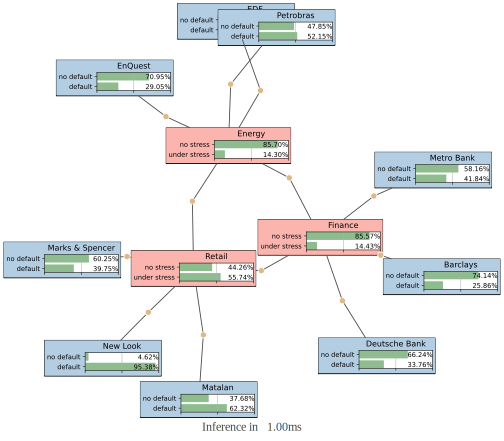

In [7]:
#gum.config['factorgraph','edge_length_inference']=1.
gnb.showInference(mn, size='7!',nodeColor=nodetypes)

### Impact of defaults on a credit portfolio and the distribution of losses

Amongst the 9 available issuers, let’s consider the following portfolio containing bonds from these 6 issuers:

In [8]:
portfolio_names = ['EDF', 'Petrobras', 'EnQuest', 'Matalan', 'Barclays']
portfolio_exposures = [2e6, 400e3, 300e3, 600e3, 3e6]
LGD = 0.9
losses = {portfolio_names[i]:(portfolio_exposures[i]*LGD) for i in range(len(portfolio_names))}

print('** Total notional: USD {} MM'.format(sum(portfolio_exposures)/1e6))

** Total notional: USD 6.3 MM


We have a USD 6.3MM total exposure to these names (notional).

We assume that in case of default, we recover only 10% (LGD = 90%).

Let’s start using the model:

In [9]:
ie = gum.ShaferShenoyMNInference(mn)
ie.makeInference()
p=ie.jointPosterior(set(sectors))

print(f'** There is {100*p[{"Retail":0,"Energy":0,"Finance":0}]:.2f}% chance that no sector in under stress.')
print()
p

** There is 42.38% chance that no sector in under stress.



(pyAgrum.Potential<double>@0000021CD885C120) 
             ||  Finance          |
Energy|Retail||no stress|under str|
------|------||---------|---------|
no str|no str|| 0.4238  | 0.0083  |
under |no str|| 0.0105  | 0.0000  |
no str|under || 0.2999  | 0.1251  |
under |under || 0.1215  | 0.0109  |

If we observe that the finance sector is doing ok, and that Marks & Spencer is still doing business as usual, then this is the current joint probabilities associated to the potential defaults in the portfolio:

In [10]:
ie = gum.ShaferShenoyMNInference(mn)
ie.addJointTarget(set(portfolio_names))
ie.setEvidence({'Finance': 'no stress', 'Marks & Spencer': 'no default'})
ie.makeInference()
portfolio_posterior = ie.jointPosterior(set(portfolio_names))

Note that the line ```ie.addJointTarget(set(portfolio_names))``` is important here because adding hard evidences removes the corresponding nodes in the graph and then no factor containing the variables in ```portfolio_names``` can be found. The method addJointTarget ensure that such a factor exists.

In [11]:
portfolio_posterior

(pyAgrum.Potential<double>@0000021CD885BE00) 
                           ||  Barclays         |
Matala|Petrob|EnQues|EDF   ||no defaul|default  |
------|------|------|------||---------|---------|
no def|no def|no def|no def|| 0.1495  | 0.0332  |
defaul|no def|no def|no def|| 0.1552  | 0.0345  |
no def|defaul|no def|no def|| 0.1268  | 0.0282  |
defaul|defaul|no def|no def|| 0.1350  | 0.0300  |
no def|no def|defaul|no def|| 0.0383  | 0.0085  |
defaul|no def|defaul|no def|| 0.0412  | 0.0092  |
[...4 more line(s) ...]
no def|defaul|no def|defaul|| 0.0081  | 0.0018  |
defaul|defaul|no def|defaul|| 0.0102  | 0.0023  |
no def|no def|defaul|defaul|| 0.0026  | 0.0006  |
defaul|no def|defaul|defaul|| 0.0034  | 0.0008  |
no def|defaul|defaul|defaul|| 0.0077  | 0.0017  |
defaul|defaul|defaul|defaul|| 0.0170  | 0.0038  |

We now want to compute the distribution of the number of defaults.
For that, we create a new Markov network containing an additional node ```Number of defaults``` connected to each issuers:

In [12]:
mn2 = gum.MarkovNet(mn)

mn2.add(gum.RangeVariable('Number of defaults', '', 0, len(portfolio_names)))
factor = mn2.addFactor(['Number of defaults',*portfolio_names]).fillWithFunction('+'.join(portfolio_names))

In [13]:
gum.config['factorgraph','edge_length']=1.1
nodetypes={n:0.1 if n in sectors else 
             0.3 if "Number of defaults"==n else
             0.2 for n in mn2.names()}
gnb.flow.add(gnb.getMN(mn2, view="graph",size='7!',nodeColor=nodetypes))
gnb.flow.add(gnb.getMN(mn2, view="factorgraph",size='7!',nodeColor=nodetypes))
gnb.flow.display()

Once this new network is created, we can obtain the distribution of ```Number of defaults``` using ```getPosterior``` :

In [14]:
ndefault_posterior = gum.getPosterior(mn2, target='Number of defaults',
                                           evs={'Finance': 'no stress', 'Marks & Spencer': 'no default'})
ndefault_posterior

(pyAgrum.Potential<double>@0000021CD885CFC0) 
  Number of defaults                                       |
0        |1        |2        |3        |4        |5        |
---------|---------|---------|---------|---------|---------|
 0.1495  | 0.3620  | 0.3119  | 0.1371  | 0.0357  | 0.0038  |

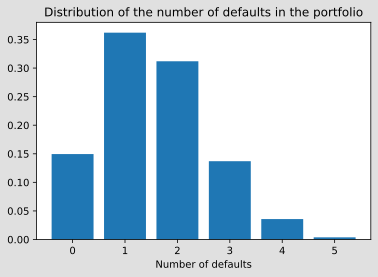

In [15]:
fig, ax = plt.subplots()
l = ndefault_posterior.tolist()
ax.bar(range(len(l)), l)
ax.set_xlabel('Number of defaults')
ax.set_title('Distribution of the number of defaults in the portfolio')
plt.show()

In [16]:
q=gum.Potential(ndefault_posterior).fillWith(range(ndefault_posterior.domainSize()))
print(f'Expected number of defaults in the portfolio: {(q*ndefault_posterior).sum():.1f}')

Expected number of defaults in the portfolio: 1.6


Besides the expected number of defaults, the distribution of losses is even more informative:

In [17]:
pot_losses = gum.Potential(portfolio_posterior)
for i in pot_losses.loopIn():
    pot_losses[i] = sum([losses[key]*i.val(key) for key in losses])
print("Table of losses")
pot_losses

Table of losses


(pyAgrum.Potential<double>@0000021CD87AD8F0) 
                           ||  Barclays         |
Matala|Petrob|EnQues|EDF   ||no defaul|default  |
------|------|------|------||---------|---------|
no def|no def|no def|no def|| 0.0000  | 2700000.0000|
defaul|no def|no def|no def|| 540000.0000| 3240000.0000|
no def|defaul|no def|no def|| 360000.0000| 3060000.0000|
defaul|defaul|no def|no def|| 900000.0000| 3600000.0000|
no def|no def|defaul|no def|| 270000.0000| 2970000.0000|
defaul|no def|defaul|no def|| 810000.0000| 3510000.0000|
[...4 more line(s) ...]
no def|defaul|no def|defaul|| 2160000.0000| 4860000.0000|
defaul|defaul|no def|defaul|| 2700000.0000| 5400000.0000|
no def|no def|defaul|defaul|| 2070000.0000| 4770000.0000|
defaul|no def|defaul|defaul|| 2610000.0000| 5310000.0000|
no def|defaul|defaul|defaul|| 2430000.0000| 5130000.0000|
defaul|defaul|defaul|defaul|| 2970000.0000| 5670000.0000|

In [18]:
expected_loss = (portfolio_posterior * pot_losses ).sum()

print(f'Expected loss with respect to a par value of USD {sum(portfolio_exposures)/1e6:.1f} MM is USD {expected_loss / 1e6:.1f} MM.')
print(f'Expected loss: {100 * expected_loss / sum(portfolio_exposures):2.1f}% of the notional.')

Expected loss with respect to a par value of USD 6.3 MM is USD 1.2 MM.
Expected loss: 18.6% of the notional.


In [19]:
cuts=list(np.percentile([pot_losses[i] for i in pot_losses.loopIn()],range(0,101,10)))
cuts[0] = cuts[0] - 0.001

loss_bucket_distribution = []
d = gum.Potential(pot_losses)
for j in range(len(cuts) - 1):
    for i in pot_losses.loopIn():
        d[i] = 1 if cuts[j]<pot_losses[i]<=cuts[j+1] else 0
    loss_bucket_distribution.append(((portfolio_posterior*d).sum()))

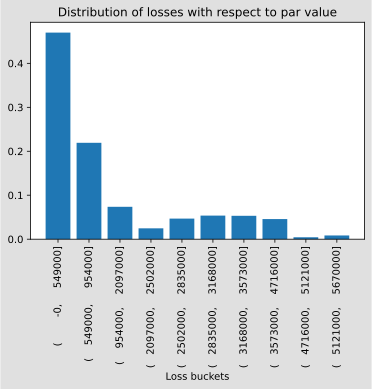

In [20]:
buckets = [f'({cuts[i]:10.0f}, {cuts[i+1]:10.0f}]' for i in range(len(cuts)-1)]

fig, ax = plt.subplots()
ax.bar(range(10), height=loss_bucket_distribution)
ax.set_xticks(range(10), labels=buckets, rotation=90)
ax.set_title('Distribution of losses with respect to par value')
ax.set_xlabel('Loss buckets')
plt.show()

In [21]:
cumsum = 0.
for i in range(len(loss_bucket_distribution)):
    cumsum += loss_bucket_distribution[i]
    print('{:24} | {:0.6f}'.format(buckets[i], cumsum))

(        -0,     549000] | 0.469960
(    549000,     954000] | 0.689263
(    954000,    2097000] | 0.762897
(   2097000,    2502000] | 0.787553
(   2502000,    2835000] | 0.834408
(   2835000,    3168000] | 0.888119
(   3168000,    3573000] | 0.941345
(   3573000,    4716000] | 0.987143
(   4716000,    5121000] | 0.991483
(   5121000,    5670000] | 1.000000


## Impact of a belief of stress on a sector for the number of defaults in the portfolio

Belief from $[1,0]$ (no stress) to $[1,1]$ (no specific belief) to $[0,1]$ (stress in a sector).


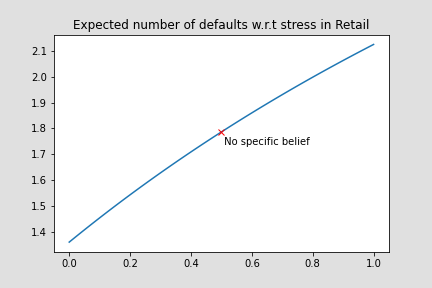
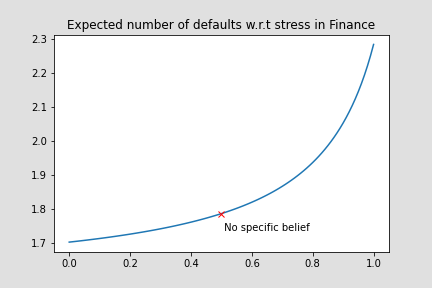
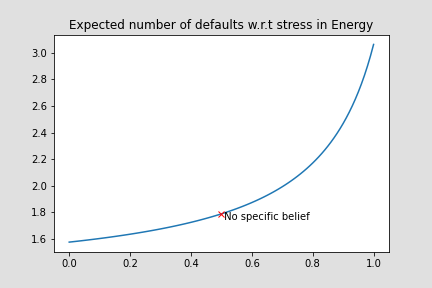

In [22]:
def show_expected_number_of_defaults(sector,q,enod_nobelief):
  v1=[]
  for i in range(101):
     posterior=gum.getPosterior(mn2, target='Number of defaults',evs={sector:[100-i,i]})
     v1.append((posterior*q).sum())

  fig, ax = plt.subplots()
  ax.set_title(f"Expected number of defaults w.r.t stress in {sector}")
  ax.plot(np.arange(0,1.01,0.01),v1)
  ax.plot(0.5,enod_nobelief,'x',color="red")
  ax.text(0.5, enod_nobelief-0.05, ' No specific belief')
  return fig

enod_nobelief=(gum.getPosterior(mn2, target='Number of defaults',evs={})*q).sum()

gnb.flow.add(show_expected_number_of_defaults('Retail',q,enod_nobelief))
gnb.flow.add(show_expected_number_of_defaults('Finance',q,enod_nobelief))
gnb.flow.add(show_expected_number_of_defaults('Energy',q,enod_nobelief))
gnb.flow.display()